# Quick visualisation and analysis of Sentinel 2 data over Ghana
### J Gómez-Dans (NCEO & UCL)

This notebooks presents a quick way to extract and analyse data from Sentinel 2. This is just a demo that highlights a limited regional extent around Tamale (Northern Ghana), but this could be extended to other areas.

The notebooks shows how the user can select a region of interest (ROI) online, using e.g. [GeoJSON.io](https://geojson.io), or [Google My Maps](https://www.google.com/mymaps), or any other way you want. You will then extract all the data that pertains to that region of interest and you can play around with it in normal Python.

Note that all the data is being accessed remotely, so it can take a little while for the code to complete. However, note that you are only downloading the bits that you require to process your data! It's around 150Gb of raw data that needs downloading and processing!


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
import gdal
gdal.UseExceptions()   

from utils import grab_holdings, extract_roi_data_ndre

img_db = grab_holdings()

/home/ucfajlg/.local/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


The previous cell has obtained a listing of all the dates in which we have data available remotely. The data covers an area of arond 100 x 200 km around Tamale, and we have nearly all the Sentinel 2 acquisitions from 2018 (there are quite a few!). Suppose you want to examine a small region defined by [this box](https://gist.github.com/jgomezdans/d2c80bc049b7fa8822c47236674ddea8/) (you may need to zoom out to actually see the location). We want to extract the data over that location. In this case, we'll extract a vegetation index, but obviously there's a lot more flexibility. We can just point to the remote file, or you can also upload a shapefile, KML, geojson file here and change `roi` to its filename.

In [2]:
roi="https://gist.github.com/jgomezdans/d2c80bc049b7fa8822c47236674ddea8/" + \
    "raw/9a0d697adbc244b26d140d3a7c524d0f2857336b/map.geojson"
analysis_data = extract_roi_data_ndre(img_db, roi=roi)

/home/ucfajlg/python/demo_ghana/utils.py:39: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(data1)):


This has taken a while. This is because all the data has been streamed from UCL's servers, as no data is stored locally. We will now just plot the vegetation index as an image. `analysis_data` is a dictionary, where the key is the data of the acquisition and the item itself is a 2D subset that matches the ROI provided earlier.

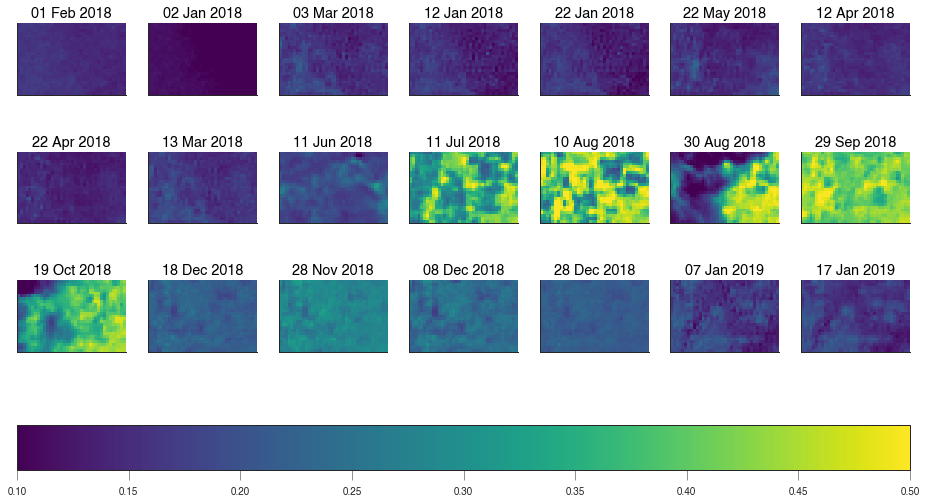

In [3]:
fig, axs = plt.subplots(nrows=3, ncols=7, sharex=True, sharey=True, figsize=(16,9))
axs = axs.flatten()
for ii, (k,v) in enumerate(analysis_data.items()):
    im =axs[ii].imshow(v, interpolation="nearest", vmin=0.1, vmax=0.5, cmap=plt.cm.viridis)
    axs[ii].set_title(k.strftime("%d %b %Y"))
    axs[ii].set_xticks([])
    axs[ii].set_yticks([])

fig.colorbar(im, ax=axs.tolist(), orientation="horizontal")



There is clearly some data. Note that we haven't filtered out clouds on Aug 30th and October 19th. The cloud mask is available but has been ignored so far. 

We can now plot a boxplot of the index distribution. Hopefully, it shows the greening up in June-November...

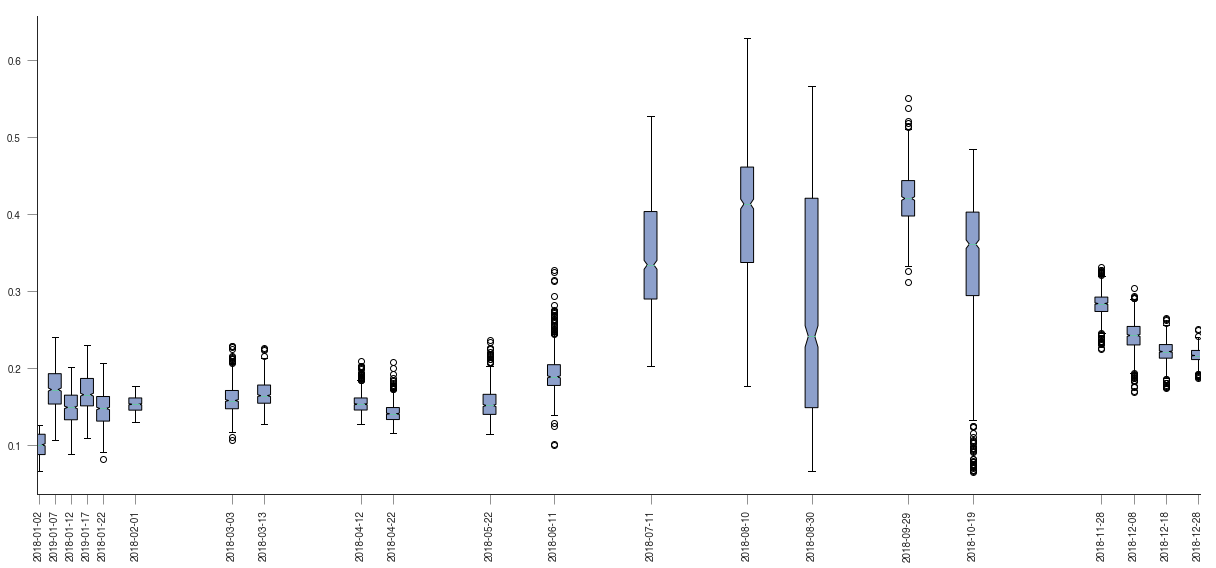

In [7]:
data = []
doys = []
tx = []
for ii, (k,v) in enumerate(analysis_data.items()):
    tx.append(k)
    doys.append(int(k.strftime("%j")))
    data.append(v.flatten())
isort = np.argsort(tx)
doys = [doys[i] for i in isort]
tx = [tx[i] for i in isort]
data = [data[i] for i in isort]
plt.figure(figsize=(17,8))    
bp = plt.boxplot(data, positions=doys, notch=True, widths=4,
                 meanline=True, patch_artist=True, labels=tx)
_ = plt.xticks(rotation="vertical")
_ = [patch.set_facecolor("#8DA0CB") for patch in bp['boxes']]
plt.tight_layout()